# AIML231 Assignment 3
> Shemaiah Rangitaawa `300601546`

This assignment focused on the design and implementation of a multi-layer perceptron neural network and the use of several machine learning techniques.

### Table of Contents
- [Part One | Linear Regression](#one)

- [Part Two | Clustering](#two)

- [Part Three | Neural Networks](#three)

<a id='ONE'></a>
# Part One | Linear Regression
> Loading MPG data and splitting data into training and testing sets
    

In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split

df = sns.load_dataset('mpg')
X = df.drop('mpg', axis=1)
y = df['mpg'] # Target

# 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=231)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


### EDA
> Data stats, scatter plots, and histograms.

In [2]:
def stats(df, exclude_feature=None):
    """
    Display basic statistics of a DataFrame.
    Args:
        df: DataFrame
        exclude_feature: str, optional
            Feature to exclude from the statistics.
    """
    if exclude_feature and exclude_feature in df.columns:
        df = df.drop(exclude_feature, axis=1)
    
    # Number of instances and features
    num_instances = df.shape[0]
    num_features = df.shape[1]
    print(f"Total number of instances: {num_instances}")
    print(f"Number of features: {num_features}")

    # Number of categorical and numerical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"Number of categorical features: {len(categorical_features)}")
    print(f"Number of numerical features: {len(numerical_features)}")

stats(df, exclude_feature='mpg')

Total number of instances: 398
Number of features: 8
Number of categorical features: 2
Number of numerical features: 6


> Scatter plots reveal relationships between the variables.

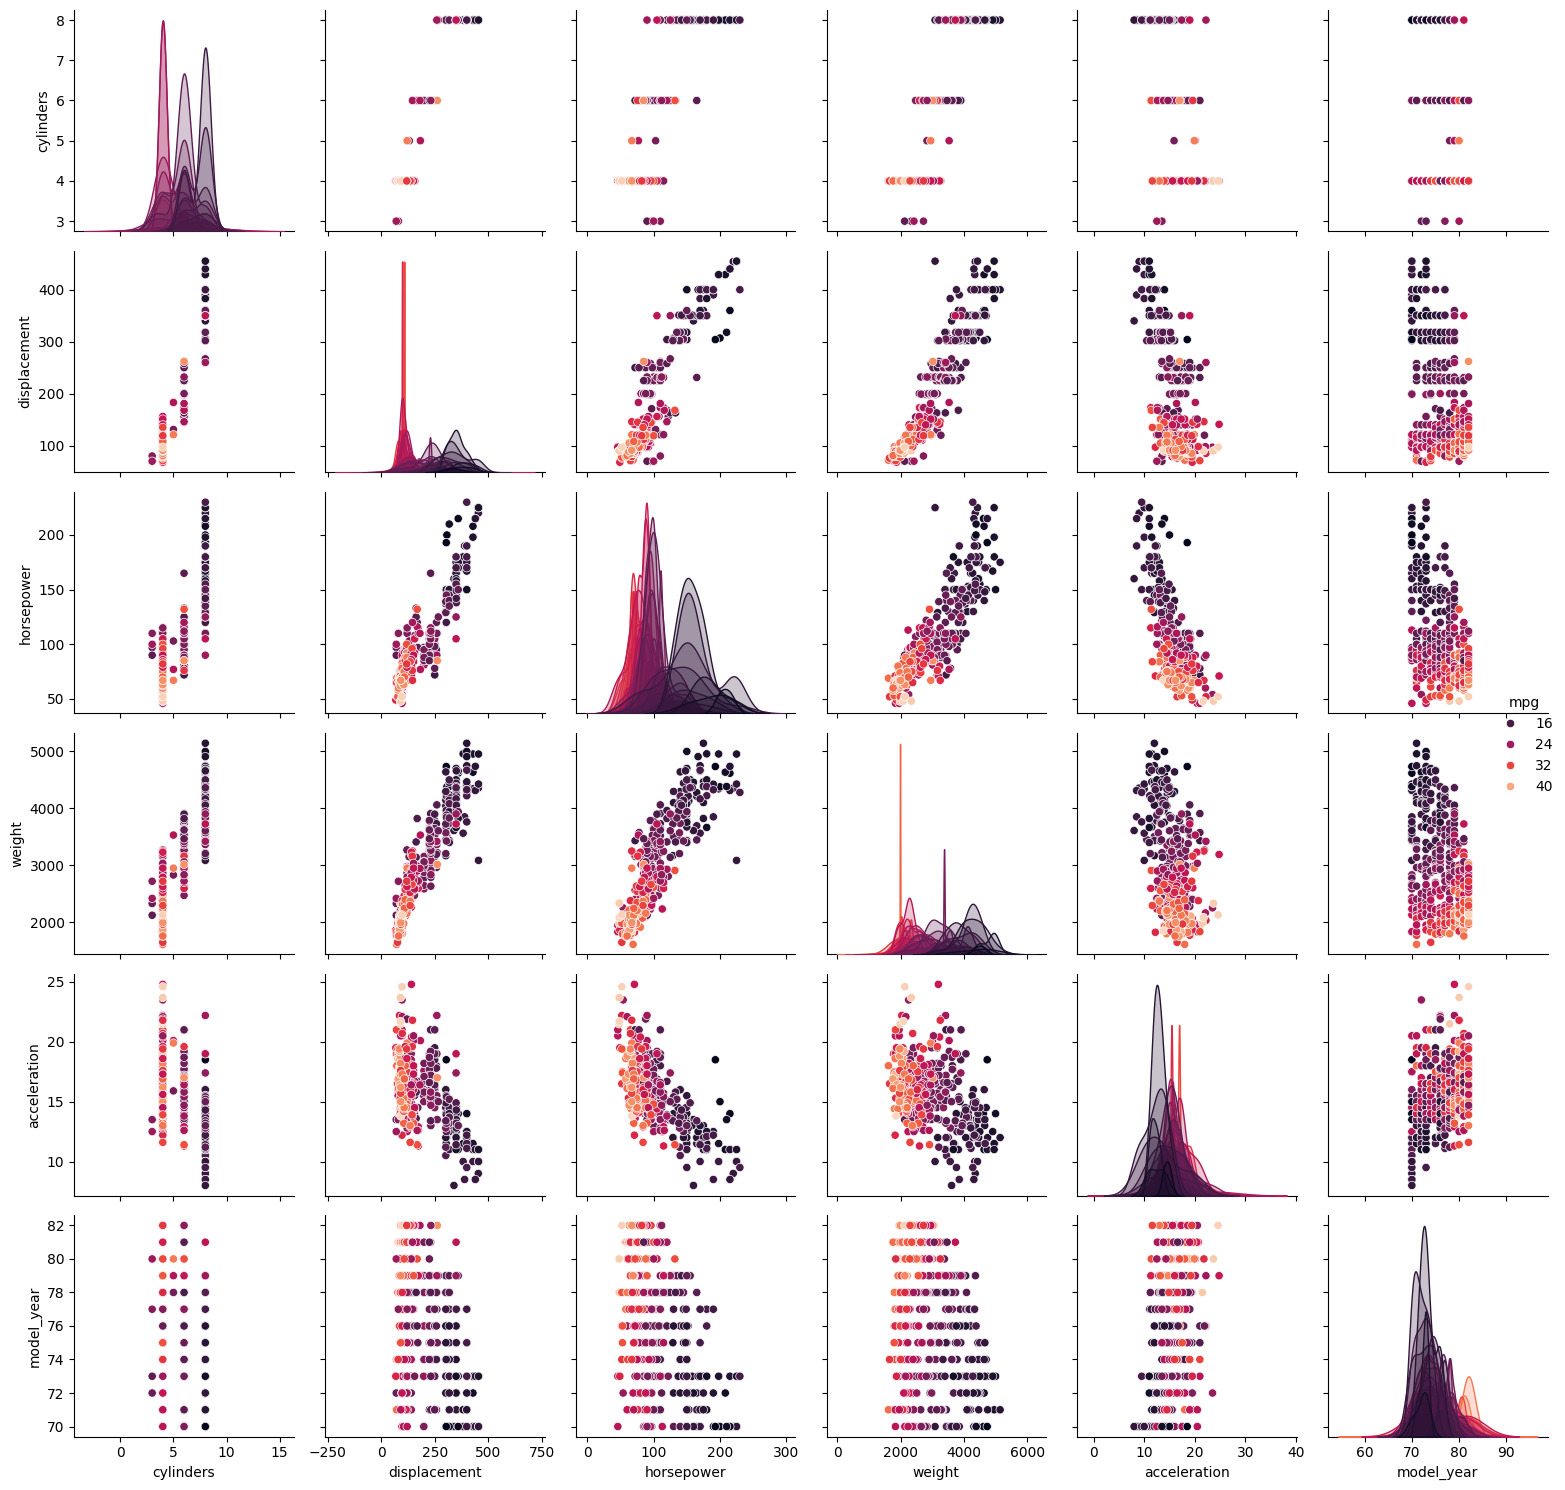

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df, diag_kind='kde', hue='mpg', palette="rocket")
plt.tight_layout()
plt.show()

> The histograms reveal the distribution of each feature.

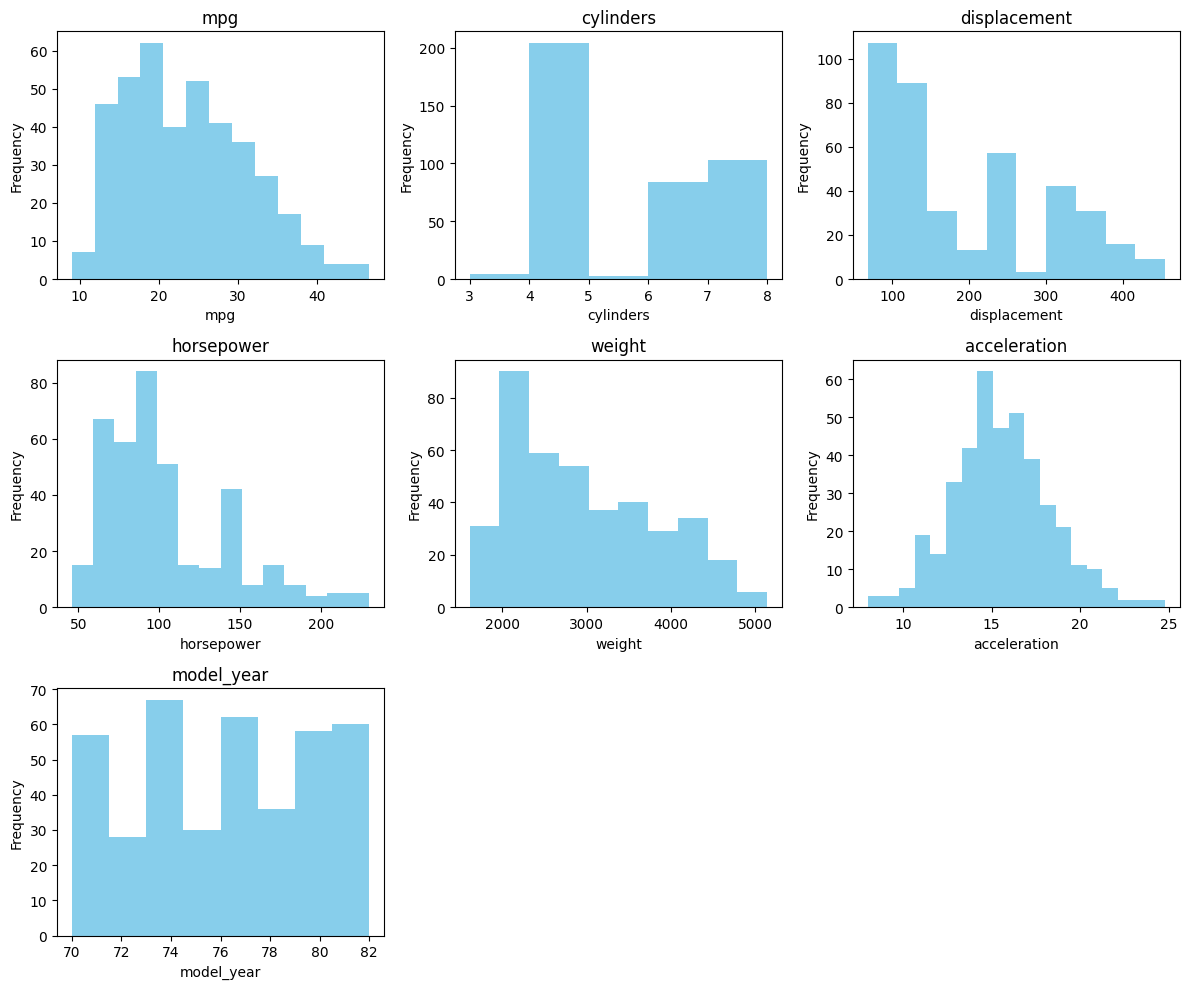

In [4]:
plt.style.use('seaborn-v0_8-muted')
axarr = df.hist(bins='fd', figsize=(12, 10), color='skyblue', grid=False) 
n_cols = len(df.columns)
axes = axarr.flatten()

for i, ax in enumerate(axes):
    ax.set_ylabel('Frequency')
    if i >= len(axes) - n_cols:
        ax.set_xlabel(ax.get_title())

plt.tight_layout()
plt.show()

### Preprocessing
> Median Imputation was used to fill in the missing values in the dataset.

In [5]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [6]:
df['horsepower'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 398 entries, 0 to 397
Series name: horsepower
Non-Null Count  Dtype  
--------------  -----  
392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [7]:
import pandas as pd
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Apply the imputer to horsepower
X_train['horsepower'] = imputer.fit_transform(X_train[['horsepower']])
X_test['horsepower'] = imputer.fit_transform(X_test[['horsepower']])

# Check if any missing values remain
X_train['horsepower'].isnull().sum(), X_test['horsepower'].isnull().sum()

(0, 0)

In [8]:
#!pip install category_encoders

> The preprocessing function encodes the features using the relevant methods and standardizes the data.

In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess(train_set, test_set):
    """ 
    This function preprocesses the data by encoding categorical features and standardizing numerical features.
    
    Args: 
        train_set: Training data
        test_set: Test data
    Returns:
        train_prepared_df: Preprocessed training data
        test_prepared_df: Preprocessed test data
        pipeline: Preprocessing pipeline
    """
    ordinal_enc = OrdinalEncoder()
    onehot_enc = OneHotEncoder(drop='if_binary', sparse_output=False)
    target_enc = TargetEncoder()

    # Defining categorical and numerical features
    categorical_features = ['cylinders', 'model_year', 'origin', 'name']
    numerical_features = train_set.columns.difference(categorical_features)

    # Set up the column transformer with appropriate transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_enc, ['cylinders']),  # Encoding 'cylinders' using ordinal encoding
            ('onehot', onehot_enc, ['model_year', 'origin']),  # 'model_year', 'origin' are nominal categories
            ('target', target_enc, ['name'])  # Encoding 'name' using target encoding
        ],
        remainder='passthrough'
    )

    # Standardize numerical features
    scaler = StandardScaler()

    # Create a pipeline that includes preprocessing and scaling
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', scaler),
    ])

    # Fit the pipeline on the training data
    train_prepared = pipeline.fit_transform(train_set, train_set['mpg'])
    test_prepared = pipeline.transform(test_set)

    # In an effort to maintain interpretability, we will retrieve the feature names after encoding
    feature_names = (
        list(preprocessor.named_transformers_['ordinal'].get_feature_names_out()) +
        list(preprocessor.named_transformers_['onehot'].get_feature_names_out()) +
        list(preprocessor.named_transformers_['target'].get_feature_names_out()) +
        list(numerical_features)
    )

    # Convert numpy arrays back to pandas DataFrame
    train_prepared_df = pd.DataFrame(train_prepared, columns=feature_names)
    test_prepared_df = pd.DataFrame(test_prepared, columns=feature_names)

    return train_prepared_df, test_prepared_df, pipeline

In [10]:
# Recombine the features and target for preprocessing
train_set = X_train.copy()
train_set['mpg'] = y_train

test_set = X_test.copy()
test_set['mpg'] = y_test

# Preprocess the data
X_train_processed, X_test_processed, _ = preprocess(train_set, test_set)
X_train_processed.head()

,cylinders,model_year_70,model_year_71,model_year_72,model_year_73,model_year_74,model_year_75,model_year_76,model_year_77,model_year_78,...,model_year_82,origin_europe,origin_japan,origin_usa,name,acceleration,displacement,horsepower,mpg,weight
0,-0.860713,-0.272625,-0.285714,-0.272625,-0.298398,-0.252082,-0.285714,-0.292103,3.581353,-0.310728,...,-0.298398,-0.492125,-0.48719,0.794210,0.218550,-0.646978,-0.200781,-0.763830,-0.013652,0.216722
1,1.413858,-0.272625,-0.285714,-0.272625,-0.298398,-0.252082,3.500000,-0.292103,-0.279224,-0.310728,...,-0.298398,-0.492125,-0.48719,0.794210,-1.115490,1.562092,1.084054,1.822673,-0.547440,-1.142473
2,-0.860713,-0.272625,-0.285714,-0.272625,-0.298398,-0.252082,-0.285714,-0.292103,3.581353,-0.310728,...,-0.298398,2.032002,-0.48719,-1.259113,-0.289656,-0.656667,0.166314,-0.401236,-0.974470,-0.301066
3,1.413858,-0.272625,-0.285714,-0.272625,-0.298398,-0.252082,-0.285714,-0.292103,-0.279224,-0.310728,...,-0.298398,-0.492125,-0.48719,0.794210,-0.924913,1.571781,0.900506,1.236480,-0.832126,-0.948302
4,1.413858,-0.272625,-0.285714,-0.272625,-0.298398,-0.252082,-0.285714,-0.292103,3.581353,-0.310728,...,-0.298398,-0.492125,-0.48719,0.794210,-0.891175,1.562092,1.739582,1.490295,-1.472671,-1.077749


In [11]:
stats(X_train_processed)

Total number of instances: 318
Number of features: 23
Number of categorical features: 0
Number of numerical features: 23


### Linear Regression Model
> The linear regression model was implemented with PyTorch.

In [42]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print('Device:', device)
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)
    print('Total Memory (GB):', torch.cuda.get_device_properties(0).total_memory / 1e9) # Convert bytes to GB
    print('Number of GPUs:', torch.cuda.device_count())
else:
    print('CUDA is not available')

Device: cuda
GPU: NVIDIA GeForce RTX 2070
CUDA version: 12.1
Total Memory (GB): 8.589606912
Number of GPUs: 1


In [50]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

n_features = X_train_processed.shape[1]
model = LinearRegression(n_features)

# Loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 4000
for epoch in tqdm(range(epochs)):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Compute the loss
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()

  0%|          | 0/4000 [00:00<?, ?it/s]

> Model evaluation on test set with MSE and R² score.

In [51]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

    # Compute MSE
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test MSE: {test_loss.item():.4f}')

    # Compute R²
    ss_res = ((y_test_tensor - predictions) ** 2).sum()
    mean_y = torch.mean(y_test_tensor)
    ss_tot = ((y_test_tensor - mean_y) ** 2).sum()
    r_squared = 1 - ss_res / ss_tot
    print(f'Test R²: {r_squared.item():.4f}')

Test MSE: 0.7781
Test R²: 0.9878


> Coefficients

In [52]:
# Extract the coefficients
coefficients = model.linear.weight.data.numpy()

# Create a DataFrame to store the coefficients
coefficients_df = pd.DataFrame(coefficients, columns=X_train_processed.columns)
coefficients_df.to_csv('data/coefficients.csv', index=False)
coefficients_df

,cylinders,model_year_70,model_year_71,model_year_72,model_year_73,model_year_74,model_year_75,model_year_76,model_year_77,model_year_78,...,model_year_82,origin_europe,origin_japan,origin_usa,name,acceleration,displacement,horsepower,mpg,weight
0,-0.003696,0.03099,0.03323,0.022502,0.009494,0.018724,-0.00396,0.013661,0.018147,0.034097,...,0.048939,0.136433,0.117128,0.14956,0.953209,0.104944,-0.071859,-0.048256,-0.006964,6.731164


> Model intercept

In [32]:
# Extract the intercept
intercept = model.linear.bias.data.numpy()
print("Intercept:", intercept)

Intercept: [23.825739]


---

<a id='two'></a>
# Part Two | Clustering